Label mapping (class -> label): {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

Confusion Matrix (rows=true, cols=predicted):
 [[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]

Per-class metrics:
 Class 0: support=50, precision=1.0000, recall=1.0000, f1=1.0000
 Class 1: support=50, precision=0.9600, recall=0.9600, f1=0.9600
 Class 2: support=50, precision=0.9600, recall=0.9600, f1=0.9600

Macro F1  : 0.9733
Micro F1  : 0.9733
Weighted F1: 0.9733

AUC per class (one-vs-rest):
 Class 0 AUC = 0.9950
 Class 1 AUC = 0.9931
 Class 2 AUC = 0.9956
Macro-average AUC = 0.9946

Regression error metrics (normal equation predictions):
 MAE = 0.165432
 MSE = 0.046385
 R2  = 0.930422


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30992\2926005723.py:184: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_sorted, fpr_sorted)


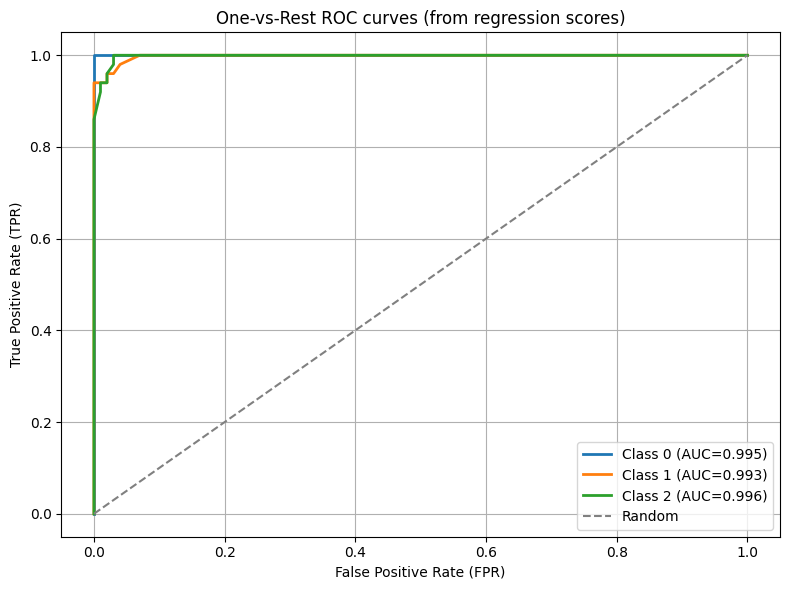

In [1]:

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------------------------
# 1) Load and preprocess data
# ---------------------------
df = pd.read_csv("Iris.csv")        # expects file in working directory
# drop Id if present
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# Map species to numeric labels  (Iris-setosa -> 0, Iris-versicolor -> 1, Iris-virginica -> 2)
df["Species"] = df["Species"].astype(str)
label_map = {lab: i for i, lab in enumerate(sorted(df["Species"].unique()))}
# (sorted ensures deterministic mapping)
df["y"] = df["Species"].map(label_map)

# Features matrix X and target y
X = df.drop(columns=["Species", "y"]).values  # shape (150, 4)
y = df["y"].values.astype(float)               # shape (150,)

# Add bias column (intercept) to X
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])  # shape (150, 5)

# ---------------------------
# 2) Linear Regression (Normal Equation)
#    theta = (X^T X)^-1 X^T y
# ---------------------------
# Compute X^T X and invert (with small regularization for numerical stability)
XtX = X_bias.T.dot(X_bias)          # shape (5,5)
# Regularization epsilon to avoid exact singularity (tiny ridge)
epsilon = 1e-8
XtX_reg = XtX + epsilon * np.eye(XtX.shape[0])

# Compute theta
theta = np.linalg.inv(XtX_reg).dot(X_bias.T).dot(y)   # shape (5,)
# Predict using normal equation
y_pred_cont = X_bias.dot(theta)                       # continuous predictions (not class labels)

# Round-to-nearest integer class for classification (not used for ROC)
y_pred_class = np.clip(np.round(y_pred_cont).astype(int), 0, len(label_map)-1)

# ---------------------------
# 3) Evaluation metrics (from scratch)
#    Confusion matrix, precision, recall, F1 (per-class),
#    Macro F1, Micro F1, Weighted F1
# ---------------------------
num_classes = len(label_map)
# Build confusion matrix: rows = true class, cols = predicted class
conf = np.zeros((num_classes, num_classes), dtype=int)
for true, pred in zip(y.astype(int), y_pred_class):
    conf[int(true), int(pred)] += 1

# Per-class TP, FP, FN
TP = np.diag(conf).astype(int)
FP = conf.sum(axis=0) - TP
FN = conf.sum(axis=1) - TP
TN = conf.sum() - (TP + FP + FN)

# Per-class precision, recall, F1 (avoid division by zero)
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1 = np.zeros(num_classes)
support = conf.sum(axis=1)   # number of true instances per class

for c in range(num_classes):
    if (TP[c] + FP[c]) > 0:
        precision[c] = TP[c] / (TP[c] + FP[c])
    else:
        precision[c] = 0.0
    if (TP[c] + FN[c]) > 0:
        recall[c] = TP[c] / (TP[c] + FN[c])
    else:
        recall[c] = 0.0
    if (precision[c] + recall[c]) > 0:
        f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
    else:
        f1[c] = 0.0

# Macro F1: unweighted mean of per-class F1
macro_f1 = f1.mean()

# Micro F1: compute global TP/FP/FN then compute F1 (micro-F1 equals micro-precision==micro-recall)
global_TP = TP.sum()
global_FP = FP.sum()
global_FN = FN.sum()
if (global_TP + global_FP) > 0:
    micro_precision = global_TP / (global_TP + global_FP)
else:
    micro_precision = 0.0
if (global_TP + global_FN) > 0:
    micro_recall = global_TP / (global_TP + global_FN)
else:
    micro_recall = 0.0
if (micro_precision + micro_recall) > 0:
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
else:
    micro_f1 = 0.0

# Weighted F1: per-class F1 weighted by class support
weighted_f1 = np.sum(f1 * support) / support.sum()

# ---------------------------
# 4) ROC Curve & AUC (one-vs-rest)
#    We need class-probability-like scores from regression outputs.
#
#    Approach:
#      For each data point with continuous regression output p,
#      compute a softmax-like score for each class c:
#         score_c = exp( - (p - c)^2 ) / sum_k exp( - (p - k)^2 )
#      This produces values in (0,1) that behave like a per-class "confidence".
#
#    Then for each class treat that class as positive and vary threshold t from 0 to 1
#    to compute TPR and FPR. Finally compute AUC via trapezoidal rule.
# ---------------------------
def continuous_to_scores(y_pred_cont, classes):
    """
    Convert continuous regression predictions to a per-class score array using
    a softmax over negative squared distances.
    Input:
        y_pred_cont: array shape (n_samples,) continuous regression outputs
        classes: iterable of class labels (0..C-1)
    Output:
        scores: shape (n_samples, C)
    """
    preds = np.array(y_pred_cont).reshape(-1, 1)      # (n,1)
    cs = np.array(list(classes)).reshape(1, -1)       # (1,C)
    # compute negative squared distances
    neg_sqdist = - (preds - cs) ** 2                  # (n,C)
    # exponentiate and normalize (softmax)
    exps = np.exp(neg_sqdist)
    exps_sum = exps.sum(axis=1, keepdims=True)
    scores = exps / exps_sum                          # (n,C), rows sum to 1
    return scores

classes = list(range(num_classes))
scores = continuous_to_scores(y_pred_cont, classes)  # shape (n_samples, C)

# Build ROC for each class
def roc_for_class(true_labels, class_scores, positive_class):
    """
    Compute FPR and TPR arrays for thresholds in [0,1] given:
      - true_labels: integer array of true class labels
      - class_scores: array of shape (n_samples,) with score for the positive_class
      - positive_class: integer
    Returns:
      - fpr_list, tpr_list, thresholds_list
    """
    # true binary labels for this one-vs-rest case
    y_true_bin = (true_labels == positive_class).astype(int)
    # thresholds: we will sweep from 0.0 to 1.0 (inclusive) with step 0.01 for resolution
    thresholds = np.linspace(0.0, 1.0, num=101)
    fpr_list = []
    tpr_list = []

    for t in thresholds:
        # predicted positive if score >= threshold
        y_pred_bin = (class_scores >= t).astype(int)
        TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
        FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))
        TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))

        # compute TPR and FPR with safe zero division handling
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return np.array(fpr_list), np.array(tpr_list), thresholds

# Compute ROC curves and AUCs for all classes
roc_data = {}
for c in classes:
    fpr, tpr, thresholds = roc_for_class(y.astype(int), scores[:, c], c)
    # Compute AUC via trapezoid rule: sort by ascending FPR (thresholds are decreasing score so ensure monotonic)
    # We sort points by FPR to be safe
    order = np.argsort(fpr)
    fpr_sorted = fpr[order]
    tpr_sorted = tpr[order]
    # trapezoidal integration
    auc = np.trapz(tpr_sorted, fpr_sorted)
    roc_data[c] = {
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "auc": auc
    }

# Macro-average AUC (mean of class AUCs)
class_aucs = np.array([roc_data[c]["auc"] for c in classes])
macro_auc = class_aucs.mean()

# ---------------------------
# 5) Error metrics for regression (from normal equation)
#    MAE, MSE, R2
# ---------------------------
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score_from_scratch(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    # If ss_tot == 0, R2 undefined (set to 0)
    return 1.0 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

mae_val = mae(y, y_pred_cont)
mse_val = mse(y, y_pred_cont)
r2_val = r2_score_from_scratch(y, y_pred_cont)

# ---------------------------
# 6) Print results
# ---------------------------
print("Label mapping (class -> label):", label_map)
print("\nConfusion Matrix (rows=true, cols=predicted):\n", conf)
print("\nPer-class metrics:")
for c in classes:
    print(f" Class {c}: support={support[c]}, precision={precision[c]:.4f}, recall={recall[c]:.4f}, f1={f1[c]:.4f}")

print(f"\nMacro F1  : {macro_f1:.4f}")
print(f"Micro F1  : {micro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print("\nAUC per class (one-vs-rest):")
for c in classes:
    print(f" Class {c} AUC = {roc_data[c]['auc']:.4f}")
print(f"Macro-average AUC = {macro_auc:.4f}")

print("\nRegression error metrics (normal equation predictions):")
print(f" MAE = {mae_val:.6f}")
print(f" MSE = {mse_val:.6f}")
print(f" R2  = {r2_val:.6f}")

# ---------------------------
# 7) (Optional) Plot ROC curves for visual inspection
# ---------------------------
plt.figure(figsize=(8,6))
for c in classes:
    plt.plot(roc_data[c]["fpr"], roc_data[c]["tpr"], label=f"Class {c} (AUC={roc_data[c]['auc']:.3f})", lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("One-vs-Rest ROC curves (from regression scores)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# End of script
# ---------------------------
